In [ ]:
# 파이썬 ≥3.5 필수

import sys

assert sys.version_info >= (3, 5)


# 사이킷런 ≥0.20 필수

import sklearn

assert sklearn.__version__ >= "0.20"


# 공통 모듈 임포트

import numpy as np

import os


# 노트북 실행 결과를 동일하게 유지하기 위해

np.random.seed(42)


# 깔끔한 그래프 출력을 위해

%matplotlib inline

import matplotlib as mpl

import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)

mpl.rc('xtick', labelsize=12)

mpl.rc('ytick', labelsize=12)


# 그림을 저장할 위치

PROJECT_ROOT_DIR = "."

CHAPTER_ID = "ensembles"

IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):

  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)

  print("그림 저장:", fig_id)

  if tight_layout:

    plt.tight_layout()

  plt.savefig(path, format=fig_extension, dpi=resolution)



## 투표기반 분류기

In [ ]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000,10)<heads_proba).astype(np.int32)
# 10000번을 던지는 실험을 10번 수행
cumulative_heads_ratio = np.cumsum(coin_tosses, axis = 0) / np.arange(1,10001).reshape(-1,1)
# 행 방향으로 누적합
# 0 0 1 ...
# ...
# ...
# 5100 5099 ... 
# 이 값들을 1000으로 나눔

(0.0, 10000.0, 0.42, 0.58)

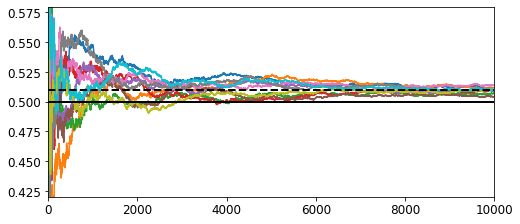

In [ ]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0,10000],[0.51,0.51],'k--', linewidth=2, label='51%')
plt.plot([0,10000],[0.5,0.5],'k-', linewidth=2, label='50%')
plt.axis([0,10000,0.42,0.58])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf),('svc',svm_clf)],
    voting='hard'
)

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


## 간접투표

In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale",probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf),('svc',svm_clf)],
    voting='soft'
)

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 배깅과 페이스팅

- 배깅 : 훈련 세트에서 중복을 허용하여 샘플링 하는 방식(붓스트랩)
- 페이스팅 : 훈련 세트에서 중복을 허용하지 않고 샘플식 하는 방식

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, # 모든 cpu코어 사용,
    random_state=42
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test
                      
                      )

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.904


In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test,y_pred_tree))

0.856


In [ ]:
from matplotlib.colors import ListedColormap


def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):

  x1s = np.linspace(axes[0], axes[1], 100)
  x2s = np.linspace(axes[2], axes[3], 100)
  x1, x2 = np.meshgrid(x1s, x2s)
  X_new = np.c_[x1.ravel(), x2.ravel()]
  y_pred = clf.predict(X_new).reshape(x1.shape)
  custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
  if contour:
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=1)
  plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
  plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
  plt.axis(axes)
  plt.xlabel(r"$x_1$", fontsize=18)
  plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: decision_tree_without_and_with_bagging_plot


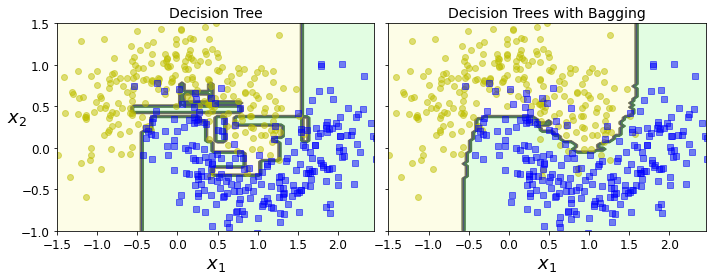

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])

plot_decision_boundary(tree_clf, X, y)

plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])

plot_decision_boundary(bag_clf, X, y)

plt.title("Decision Trees with Bagging", fontsize=14)

plt.ylabel("")

save_fig("decision_tree_without_and_with_bagging_plot")

plt.show()



In [ ]:
y_pred

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

## oob 평가

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_


0.896

## 랜덤 포레스트

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500,
                                 max_leaf_nodes=16,
                                 n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500,
                                 random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)


sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100,
                                 random_state=42)
rnd_clf.fit(mnist["data"], mnist['target'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
def plot_digit(data):
  imange = data.reshape(28,28)
  plt.imshow(imange, cmap=mpl.cm.hot,
             interpolation="nearest")
  plt.axis("off")

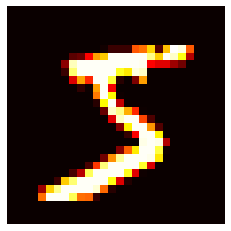

In [ ]:
plot_digit(mnist["data"][:1])

그림 저장: mnist_feature_importance_plot


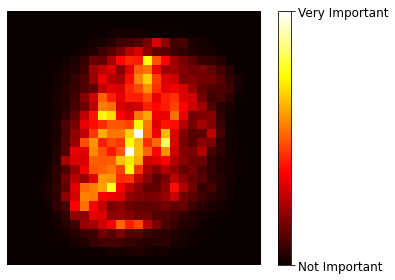

In [ ]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(["Not Important","Very Important"])

save_fig("mnist_feature_importance_plot")
plt.show()

## 에이다 부스팅

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5
)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

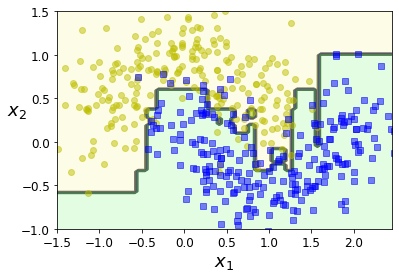

In [ ]:
plot_decision_boundary(ada_clf, X,y)

그림 저장: boosting_plot


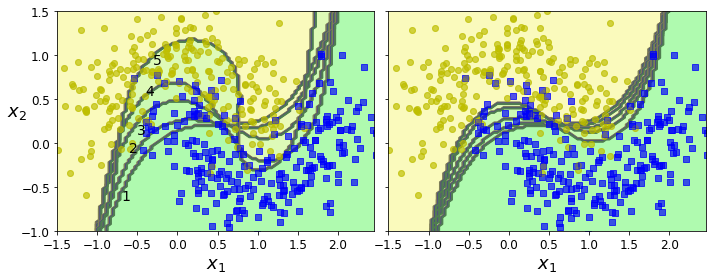

In [ ]:
m = len(X_train)

fix,axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0,1), (1,0.5)):
  sample_weights= np.ones(m) # 맨 처음 샘플 가중치 1
  plt.sca(axes[subplot])
  for i in range(5):
    svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
    svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = svm_clf.predict(X_train)
    sample_weights[y_pred != y_train] *= (1 + learning_rate)
    # 잘못 맞춘 샘플들의 가중치를 조정
    # 한번은 1, 한번은 0.5 씩 가중치를 높임
    plot_decision_boundary(svm_clf, X, y, alpha=0.2)
  if subplot == 0:
    plt.text(-0.7, -0.65, "1", fontsize=14)
    plt.text(-0.6, -0.10, "2", fontsize=14)
    plt.text(-0.5, 0.10, "3", fontsize=14)
    plt.text(-0.4, 0.55, "4", fontsize=14)
    plt.text(-0.3, 0.90, "5", fontsize=14)
  else:
    plt.ylabel("")

save_fig("boosting_plot")
plt.show()



In [ ]:
ada_clf.estimator_weights_ # SAMME.R 알고리즘에서는 가중치가 1로 동일 (확률을 기반으로 예측하기 때문에)
# SAM# SAMME 알고리즘일때는 가중치가 다름 -> 투표 기반이기 때문에
# sample 가중치는 두 알고리즘 모두 다름

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## 그래디언트 부스팅

In [ ]:
np.random.seed(42)
X = np.random.rand(100,1) - 0.5
y = 3*X[:,0]**2 + 0.05 * np.random.randn(100)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
y2 = y - tree_reg1.predict(X) # 실제값과 예측값의 차이
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X,y2) # 실제값과 예측값의 차이에 다시 한번 결정트리 모델 적용

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
X_new=np.array([[0.8]])
X_new

array([[0.8]])

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))
y_pred


array([0.75026781])

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
  x1 = np.linspace(axes[0], axes[1], 500)
  y_pred = sum(regressor.predict(x1.reshape(-1,1)) for regressor in regressors)
  plt.plot(X[:,0], y, data_style, label=data_label)
  plt.plot(x1,y_pred, style, linewidth=2, label=label)
  if label or data_label:
    plt.legend(loc="upper center", fontsize=16)
  plt.axis(axes)

그림 저장: gradient_boosting_plot


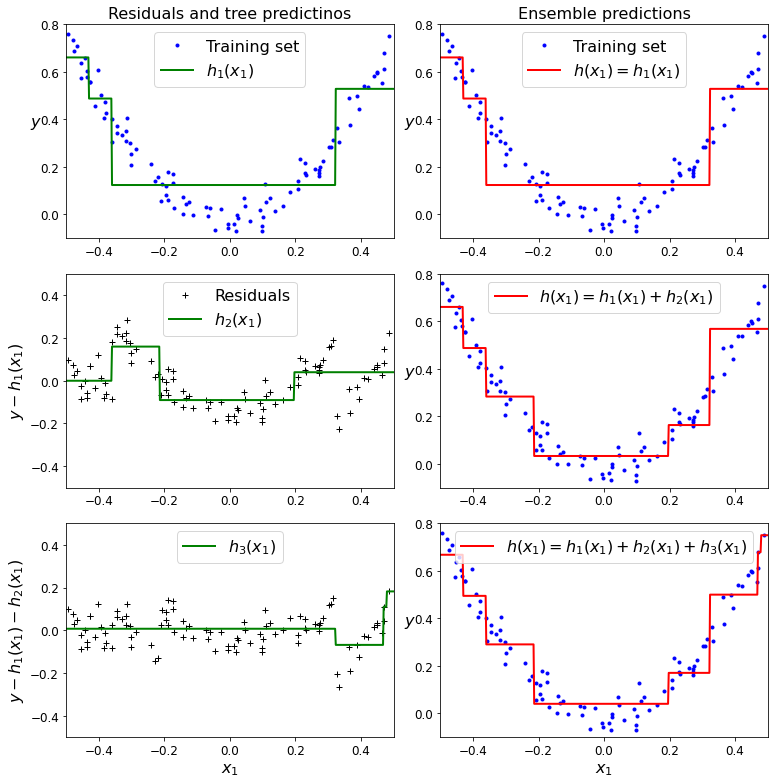

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1],X,y, axes=[-0.5,0.5,-0.1,0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictinos", fontsize=16)

plt.subplot(322)

plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")

plt.ylabel("$y$", fontsize=16, rotation=0)

plt.title("Ensemble predictions", fontsize=16)


plt.subplot(323)

plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")

plt.ylabel("$y - h_1(x_1)$", fontsize=16)


plt.subplot(324)

plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.ylabel("$y$", fontsize=16, rotation=0)


plt.subplot(325)

plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")

plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)

plt.xlabel("$x_1$", fontsize=16)


plt.subplot(326)

plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")

plt.xlabel("$x_1$", fontsize=16)

plt.ylabel("$y$", fontsize=16, rotation=0)


save_fig("gradient_boosting_plot")

plt.show()



- learning_rate = 0.1 처럼 낮게 설정하면 앙상블을 학습에 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋음

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state =42)
gbrt.fit(X,y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state =42)
gbrt_slow.fit(X,y)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

그림 저장: gbrt_learning_rate_plot


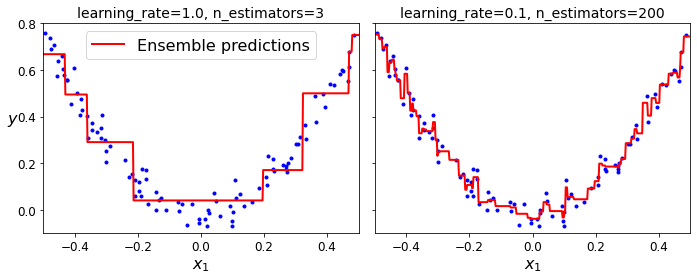

In [ ]:
fix,axes=plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])

plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")

plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.xlabel("$x_1$", fontsize=16)

plt.ylabel("$y$", fontsize=16, rotation=0)


plt.sca(axes[1])

plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])

plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.xlabel("$x_1$", fontsize=16)


save_fig("gbrt_learning_rate_plot")

plt.show()



왼쪽은 트리 부족 오른쪽은 과대적합
-> 최적의 트리 수를 찾아야 함

staged_predict() 메서드로 조기종료 기법을 사용해 최적의 트리 수를 찾음


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120,random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)+1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
min_error = np.min(errors)


그림 저장: early_stopping_gbrt_plot


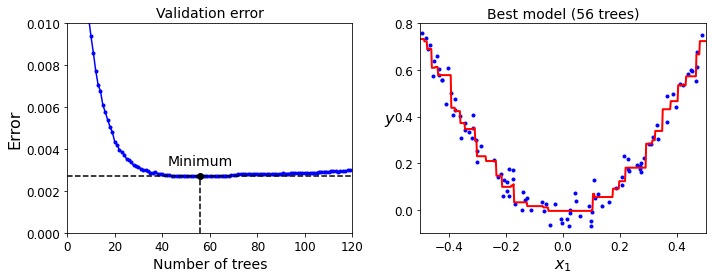

In [ ]:
plt.figure(figsize=(10, 4))


plt.subplot(121)

plt.plot(errors, "b.-")

plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")

plt.plot([0, 120], [min_error, min_error], "k--")

plt.plot(bst_n_estimators, min_error, "ko")

plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)

plt.axis([0, 120, 0, 0.01])

plt.xlabel("Number of trees")

plt.ylabel("Error", fontsize=16)

plt.title("Validation error", fontsize=14)


plt.subplot(122)

plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])

plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.ylabel("$y$", fontsize=16, rotation=0)

plt.xlabel("$x_1$", fontsize=16)


save_fig("early_stopping_gbrt_plot")

plt.show()



# XGBoost 
- 히스토그램 기반 부스팅 알고리즘
- 속도와 일반화 성능 모음 높음
- 사이킷런에 있지 않음

In [ ]:
import xgboost

In [ ]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
# 기본값 n_estimators=100, max_depth=3
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[01:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_pred

array([ 1.8133688e-01,  1.8133688e-01, -3.8414419e-02,  1.8425870e-01,
        4.8237413e-02, -1.1697412e-02, -1.6712844e-02,  8.8122964e-02,
        5.9836417e-01,  5.8294713e-01,  3.6986542e-01,  2.7801144e-01,
        3.6986542e-01,  1.6290128e-02,  5.8055854e-01,  9.3018264e-02,
        1.2511951e-01,  3.8400292e-02,  5.8055854e-01, -2.1797419e-04,
        1.8133688e-01,  5.8055854e-01,  2.3275834e-01,  4.3506175e-01,
        6.7720068e-01], dtype=float32)

In [ ]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val,y_val)], early_stopping_rounds=2)
# 2번 부스팅해도 mse가 좋아지지 않으면 조기종료
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[01:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse

32번째보다 33번째 rmse가 높기 때문에 조기종료

In [ ]:
# lightgbm 마이크로소프트에서 만든 히스토그램 기반 부스팅 알고리즘
from lightgbm import LGBMRegressor

lgb_reg = LGBMRegressor(random_state=42)
lgb_reg.fit(X_train, y_train)

y_pred = lgb_reg.predict(X_val반
val_error = mean_squared_error(y_val, y_pred)
val_error

0.01777549654697777

In [ ]:
%timeit LGBMRegressor().fit(X_train, y_train)

100 loops, best of 3: 5.21 ms per loop


In [ ]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train)

[02:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

10 loops, best of 3: 21.1 ms per loop


# 최근에 나온 LightGBM 알고리즘이 가장 빠름